In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
import math
from timefusion import TimeFusion
from torch import nn
from data import TimeFusionDataset
from torch.utils.data import DataLoader

In [2]:
# Create dataset of two correlated, random walks on top of sine functions
# Set random seed to make result reproducible
np.random.seed(0)

# Random walk starts at 0,0
z = np.array([0,0])

# Covariance matrix for normal distribution
cov = [
    [1, 0.5],
    [0.5, 1]
]

# List to hold samples
samples = []

for i in range(60000):

    # Calculate underlying sine values
    y = 150*np.array([np.sin(i/40),np.sin((i/25))])
    #y = 1*np.array([np.sin(0.04*i),np.sin(0.04*i)])

    # Draw random samples from normal distribution
    z = np.random.multivariate_normal(z,cov)
    #z = np.array([0,0])

    # Store samples
    samples.append(y + z)

# Create pandas DataFrame out of data
data = pd.DataFrame(data=samples,columns=["sine1","sine2"])

data.index = [pd.Timestamp('2000-01-01 00:00:00') + pd.DateOffset(hours=i) for i in range(len(data.index))]

# Remove 50% of samples to make into an irregular time-series
keep = 0.20 # What fraction of cells to keep
mask = [False]*int(2*len(data)*keep) + [True]*int(2*len(data)*(1-keep))
random.shuffle(mask)
mask = np.array(mask).reshape((len(data),2))
data = data.mask(mask)

# Remove all rows without any data
data = data.dropna(axis = 0, how = 'all')




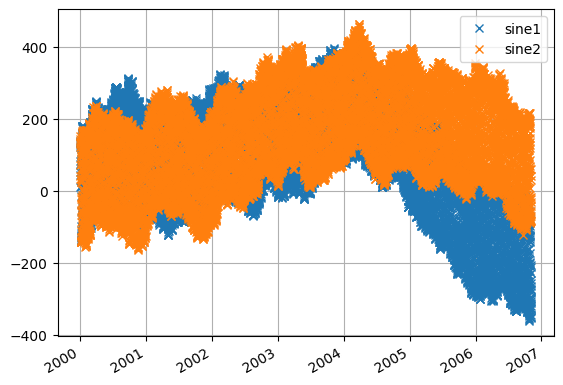

In [3]:
# Plot data so we can inspect it
data[:].plot(marker="x",linewidth=0)
plt.grid(True)

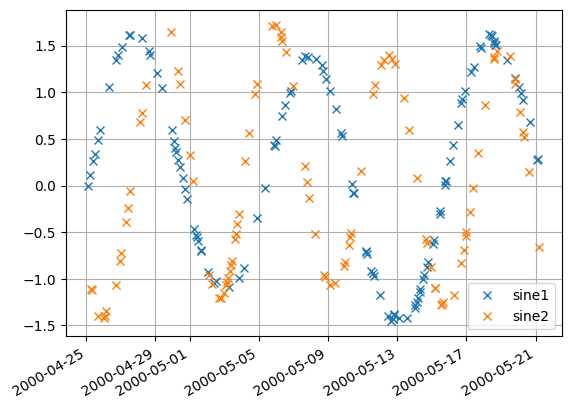

In [4]:
# Detrend data by subtracting running mean and dividing by running variance
#data - data.rolling(200).mean()
data -= data.rolling(100,min_periods=30).mean()
data /= data.rolling(200,min_periods=60).std()

data = data[1000:]

# Replot data
data[:200].plot(marker='x',linewidth=0)
plt.grid(True)

In [5]:
# Define some common variables
device = torch.device("cpu")
context_length = 50 
prediction_length = 30

encodings = [
    lambda x: math.sin(2*math.pi*x.timestamp() / (3600*24)),
    lambda x: math.sin(2*math.pi*x.timestamp() / (3600*24*5)),
    lambda x: math.sin(2*math.pi*x.timestamp() / (3600*24*10)),
    lambda x: math.cos(2*math.pi*x.timestamp() / (3600*24)),
    lambda x: math.cos(2*math.pi*x.timestamp() / (3600*24*5)),
    lambda x: math.cos(2*math.pi*x.timestamp() / (3600*24*10)),
]

# Create each dataset
train_data = TimeFusionDataset(
    data = data.iloc[:int(0.2*len(data))],
    context_length = context_length,
    prediction_length = prediction_length,
    timestamp_encodings = encodings
)

val_data = TimeFusionDataset(
    data = data.iloc[int(0.95*len(data)):],
    context_length = context_length,
    prediction_length = prediction_length,
    timestamp_encodings = encodings
)

train_loader = DataLoader(
    dataset = train_data,
    shuffle = True,
    num_workers = 2,
    batch_size = 64
)

val_loader = DataLoader(
    dataset = val_data,
    shuffle = True,
    num_workers = 0,
    batch_size = 64
)

In [6]:
predictor = TimeFusion(
    context_length = 50,
    prediction_length = 30,
    timeseries_shape = (len(train_data.time_series),train_data.time_series[0].shape[1]), 
    num_encoder_layers=3,
    d_model=64,
    nhead=4,
    dim_feedforward=128,
    diff_steps=100,
    device = device,
)

#predictor = torch.compile(predictor)

/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/TimeFusion/diffusion.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bar_alphas = torch.tensor(


In [7]:
print("Number of trainable parameters:",sum(p.numel() for p in predictor.parameters()))

Number of trainable parameters: 101634


In [8]:
optimizer = torch.optim.Adam(params=predictor.parameters(),lr=2e-4)
lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.01, total_iters=60)

predictor.train_network(
    train_loader = train_loader,
    epochs=40,
    val_loader = val_loader,
    val_metrics= {
        "Val MAE": nn.L1Loss(),
        "Val MSE": nn.MSELoss()
    },
    optimizer = optimizer,
    #lr_scheduler= lr_scheduler
)


 |==============================|  Batch: 63 / 63, Epoch: 1 / 40, Average Loss: 0.7892, Val MAE: 0.5600, Val MSE: 0.5492


In [ ]:
sample_index = 400

timestamps = []
for col in range(val_data.indices.shape[1]):
    timestamps.append(list(val_data.data_copy.iloc[sample_index:,col].dropna().index[:predictor.prediction_length]))

timestamps = np.array(timestamps)

samples = predictor.sample(
    data = val_data,
    sample_indices = timestamps,
    num_samples = 100,
    timestamp_encodings = encodings
)


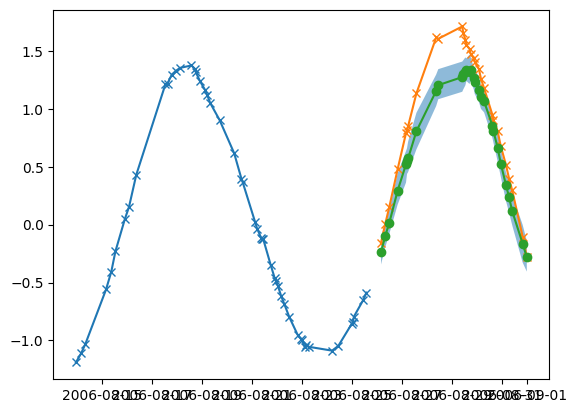

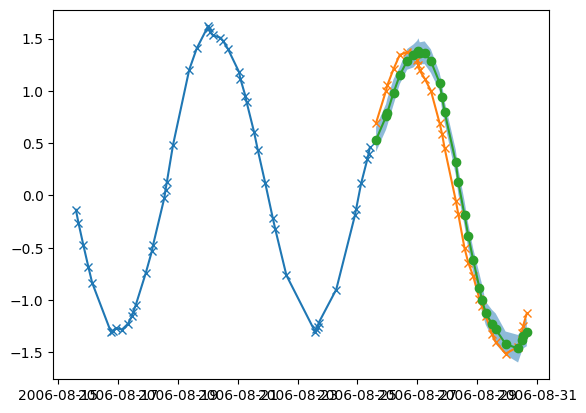

In [ ]:
# Plot the samples
confidence = 0.1

samples_cpu = samples.cpu()
samples_cpu[:,0,:], _= torch.sort(samples_cpu[:,0,:],dim=0)
samples_cpu[:,1,:], _ = torch.sort(samples_cpu[:,1,:],dim=0)

plt.figure()
plt.plot(val_data.data_copy.iloc[:400,0].dropna().iloc[-predictor.context_length:],"-x")
plt.plot(val_data.data_copy.iloc[400:,0].dropna().iloc[:predictor.prediction_length],"-x")
plt.fill_between(timestamps[0], samples_cpu[int(confidence*samples_cpu.shape[0]),0,:], samples_cpu[int((1-confidence)*samples_cpu.shape[0]),0,:],alpha=0.5)
plt.plot(timestamps[0],torch.mean(samples.cpu(),axis=0)[0],"-o")

plt.figure()
plt.plot(val_data.data_copy.iloc[:400,1].dropna().iloc[-predictor.context_length:],"-x")
plt.plot(val_data.data_copy.iloc[400:,1].dropna().iloc[:predictor.prediction_length],"-x")
plt.fill_between(timestamps[1], samples_cpu[int(confidence*samples_cpu.shape[0]),1,:], samples_cpu[int((1-confidence)*samples_cpu.shape[0]),1,:],alpha=0.5)
plt.plot(timestamps[1],torch.mean(samples.cpu(),axis=0)[1],"-o")
